In [1]:
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from scipy.stats.kde import gaussian_kde
from numpy import linspace
from copy import deepcopy
from src.fewshot_ner_viz_component.fewshot_ner_binary_classifier import FewshotNerBinaryClassifier, CompositeEmbedder
from src.fewshot_ner_viz_component.data_processing import *

/home/kostrovskiy/prog/AI/NLP/DeepPavlov/env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
[nltk_data] Downloading package punkt to
[nltk_data]     /home/kostrovskiy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kostrovskiy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     /home/kostrovskiy/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /home/kostrovskiy/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!
2018-08-21 14:57:32.649 DEBU

In [2]:
dataset_orig = read_data()

Num of train sentences: 75187
Num of valid sentences: 9603
Num of test sentences: 9479
[(['Actions', 'had', 'to', 'be', 'taken', 'to', 'break', 'through', 'the', 'blockade', '.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['On', 'a', 'night', 'in', 'late', 'July', '1940', ',', 'the', 'atmosphere', 'in', 'Zhuanbi', 'Village', 'in', 'Shaanxi', 'was', 'unusual', '.'], ['O', 'B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'B-GPE', 'I-GPE', 'O', 'B-GPE', 'O', 'O', 'O']), (['Villager', 'Xiao', 'Jianghe', 'has', 'a', 'vivid', 'memory', 'of', 'this', 'piece', 'of', 'history', '.'], ['O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['On', 'that', 'dark', 'night', ',', 'everyone', 'was', 'sleeping', 'when', 'human', 'voices', 'and', 'neighing', 'horses', 'were', 'heard', 'within', 'the', 'village', '.'], ['O', 'B-TIME', 'I-TIME', 'I-TIME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

In [3]:
ne_type = 'PERSON'
dataset = filter_dataset_by_ne_types(dataset_orig, ne_type)

Num of train sentences: 12195
Num of valid sentences: 1553
Num of test sentences: 1573


In [4]:
embedder = CompositeEmbedder(use_elmo=False, elmo_scale=1, cap_scale=1, use_cap_feat=False, use_glove=True)

2018-08-21 14:57:46.635 INFO in 'deeppavlov.models.embedders.glove_embedder'['glove_embedder'] at line 60: [loading embeddings from `/home/kostrovskiy/prog/AI/NLP/DeepPavlov/download/embeddings/glove.6B/glove.6B.100d.txt`]
2018-08-21 14:57:46.636 INFO in 'gensim.models.keyedvectors'['keyedvectors'] at line 204: loading projection weights from /home/kostrovskiy/prog/AI/NLP/DeepPavlov/download/embeddings/glove.6B/glove.6B.100d.txt
2018-08-21 14:57:46.637 DEBUG in 'smart_open.smart_open_lib'['smart_open_lib'] at line 176: {'kw': {}, 'mode': 'rb', 'uri': '/home/kostrovskiy/prog/AI/NLP/DeepPavlov/download/embeddings/glove.6B/glove.6B.100d.txt'}
2018-08-21 14:58:19.506 INFO in 'gensim.models.keyedvectors'['keyedvectors'] at line 266: loaded (400000, 100) matrix from /home/kostrovskiy/prog/AI/NLP/DeepPavlov/download/embeddings/glove.6B/glove.6B.100d.txt


In [5]:
def get_matrices(tokens, tags, embedder):
    return (embeddings2feat_mat(embedder.embed(tokens), get_tokens_len(tokens)), 
           tags2binaryFlat(tags))

In [6]:
def get_batch(dataset, embedder):
    n_support_sen = 10
    n_query_sen = 10
    n_samples = n_support_sen + n_query_sen
    tokens, tags = get_data_sample(dataset['train'], n_support_sen + n_samples)
    tokens_support = tokens[:n_support_sen]
    tags_support = tags[:n_support_sen]
    tokens_query = tokens[n_support_sen:]
    tags_query = tags[n_support_sen:]
    X_support, y_support = get_matrices(tokens_support, tags_support, embedder)
    X_query, y_query = get_matrices(tokens_query, tags_query, embedder)
    return X_support, y_support, X_query, y_query

In [7]:
def encoder(x, params):
#     print('x.shape: {}'.format(x.get_shape()))
    weights =  params['weights']
    biases = params['biases']
#     print('W1.shape: {}'.format(weights[0].get_shape()))
    n_layers = len(weights)
    signals = [None]*(n_layers + 1)
    signals[0] = x
    for i in range(n_layers):
        signals[i+1] = tf.nn.sigmoid(tf.add(tf.matmul(signals[i], weights[i], transpose_b=True), biases[i]))
    out = signals[-1]
    return out

In [8]:
def normalize_tf(x):
    return x/tf.tile(tf.expand_dims(tf.norm(x1, axis=-1), axis=-1))
def calc_sim_tf(x1, x2, sim_type='cosine'):
    if sim_type == 'euc_dist':
        return tf.exp(-tf.norm(x1 - x2, axis=-1))
    elif sim_type == 'dot_prod':
        return tf.matmul(x1, x2, transpose_b=True)
    elif sim_type == 'cosine':
        return tf.matmul(tf.nn.l2_normalize(x1, axis=-1), tf.nn.l2_normalize(x2, axis=-1), transpose_b=True)

In [9]:
def build_model(params, X_support, y_support, X_query, y_query, verbose=False):
    
#     if verbose:
#         print('X_support.shape: {}'.format(tf.shape(X_support)))
    
    # Calculate initial similarities
    X_sup_ne = tf.gather(X_support, tf.squeeze(tf.where(tf.equal(y_support, 1))), axis=-2)
    ne_sup_centroid = tf.reduce_mean(X_sup_ne, axis=-2, keepdims=True)
    sims = calc_sim_tf(X_query, ne_sup_centroid, sim_type='cosine')
    n_query_tokens = tf.shape(X_query)[-2]
    sims_ne = tf.squeeze(tf.gather(sims, tf.squeeze(tf.where(tf.equal(y_query, 1))), axis=-2))
    sims_words = tf.squeeze(tf.gather(sims, tf.squeeze(tf.where(tf.equal(y_query, 0))), axis=-2))
    d_sim = tf.reduce_mean(sims_ne) - tf.reduce_mean(sims_words)
    
    # Make encoding
    f_support = encoder(X_support, params)
    f_query = encoder(X_query, params)
    
    f_sup_ne = tf.gather(f_support, tf.squeeze(tf.where(tf.equal(y_support, 1))), axis=-2)
    f_sup_words = tf.gather(f_support, tf.squeeze(tf.where(tf.equal(y_support, 0))), axis=-2)
    
#     if verbose:
#         print('f_sup_ne.shape: {}'.format(tf.shape(f_sup_ne)))
#         print('f_sup_words: {}'.format(tf.shape(f_sup_words)))
    
    ne_sup_centroid_f = tf.reduce_mean(f_sup_ne, axis=-2, keepdims=True)
#     if verbose:
#         print('ne_supp_centroid.shape: {}'.format(tf.shape(ne_supp_centroid)))
    
    f_query = encoder(X_query, params)
    
    sim_ne_centroid_f = calc_sim_tf(f_query, ne_sup_centroid_f, sim_type='cosine')
    sim_words_f = calc_sim_tf(f_query, f_sup_words, sim_type='cosine')
    
    objective = tf.squeeze(sim_ne_centroid_f) - tf.reduce_mean(tf.squeeze(sim_words_f), axis=-1)
    
    loss = tf.reduce_mean((1-2*y_query)*objective)
    
    sim_q_cent_ne_f = tf.gather(sim_ne_centroid_f, tf.squeeze(tf.where(tf.equal(y_query, 1))), axis=-2)
    sim_q_cent_words_f = tf.gather(sim_ne_centroid_f, tf.squeeze(tf.where(tf.equal(y_query, 0))), axis=-2)
    d_sim_f = tf.reduce_mean(tf.squeeze(sim_q_cent_ne_f)) - tf.reduce_mean(tf.squeeze(sim_q_cent_words_f))
    
    return loss, d_sim, d_sim_f

In [10]:
# n_input = 1024
# n_hidden1 = 512
# n_output = 256
n_input = embedder.embed_size
n_hidden1 = math.ceil(n_input/2)
n_output = math.ceil(n_hidden1/2)

weights = [tf.get_variable(name='h1', shape=(n_hidden1, n_input), initializer=tf.contrib.layers.xavier_initializer()),
            tf.get_variable(name='w_out', shape=(n_output, n_hidden1), initializer=tf.contrib.layers.xavier_initializer())]
biases = [tf.get_variable(name='b1', shape=(n_hidden1), initializer=tf.contrib.layers.xavier_initializer()),
            tf.get_variable(name='b_out', shape=(n_output), initializer=tf.contrib.layers.xavier_initializer())]

params = {'weights': weights, 'biases': biases}

X_support = tf.placeholder('float', [None, n_input])
y_support = tf.placeholder('float', [None])
X_query = tf.placeholder('float', [None, n_input])
y_query = tf.placeholder('float', [None])

### Train model

In [11]:
n_epochs = 5
n_steps = 10
loss, d_sim, d_sim_f = build_model(params, X_support, y_support, X_query, y_query)
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss)
sess = tf.Session()
sess.run(tf.initialize_all_variables())
loss_list = []
d_sim_f_list = []
d_sim_list = []
for epoch in range(n_epochs):
    print('Epoch {}'.format(epoch+1))
    for step in range(n_steps):
        X_support_batch, y_support_batch, X_query_batch, y_query_batch = get_batch(dataset, embedder)
#         print(X_support_batch.shape)
#         print(X_query_batch.shape)
        print('Step {}/{}'.format(step+1, n_steps))
        feed = {X_support: X_support_batch, y_support: y_support_batch, X_query: X_query_batch, y_query: y_query_batch}
        _, loss_cur, d_sim_cur, d_sim_f_cur = sess.run([train_op, loss, d_sim, d_sim_f], feed_dict=feed)
        loss_list.append(loss_cur)
        d_sim_list.append(d_sim_cur)
        d_sim_f_list.append(d_sim_f_cur)
    print('train loss = {}, d_sim = {}, d_sim_f = {}'.format(loss_cur, d_sim_cur, d_sim_f_cur))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


2018-08-21 14:58:20.616 WARNING in 'tensorflow'['tf_logging'] at line 126: From /home/kostrovskiy/prog/AI/NLP/DeepPavlov/env/lib/python3.6/site-packages/tensorflow/python/util/tf_should_use.py:118: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Epoch 1
Step 1/10
Step 2/10
Step 3/10
Step 4/10
Step 5/10
Step 6/10
Step 7/10
Step 8/10
Step 9/10
Step 10/10
train loss = -0.0010448178509250283, d_sim = -0.13533934950828552, d_sim_f = 0.0018138289451599121
Epoch 2
Step 1/10
Step 2/10
Step 3/10
Step 4/10
Step 5/10
Step 6/10
Step 7/10
Step 8/10
Step 9/10
Step 10/10
train loss = -0.00541772460564971, d_sim = -0.07738801836967468, d_sim_f = 0.006608545780181885
Epoch 3
Step 1/10
Step 2/10
Step 3/10
Step 4/10
Step 5/10
Step 6/10
Step 7/10
Step 8/10
Step 9/10
Step 10/10
train loss = -0.02363957278430462, d_sim = -0.047368764877319336, d_sim_f = 0.024785399436950684
Epoch 4
Step 1/10
Step 2/10
Step 3/10
Step 4/10
Step 5/10
Step 6/10
Step 7/10
Step 8/10
Step 9/10
Step 10/10
train loss = -0.051323022693395615, d_sim = 4.4465065002441406e-05, d_sim_f = 0.052625298500061035
Epoch 5
Step 1/10
Step 2/10
Step 3/10
Step 4/10
Step 5/10
Step 6/10
Step 7/10
Step 8/10
Step 9/10
Step 10/10
train loss = -0.09995853900909424, d_sim = -0.13591042160987854,

2018-08-21 14:58:21.280 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1343: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/kostrovskiy/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2018-08-21 14:58:21.318 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1343: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/kostrovskiy/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


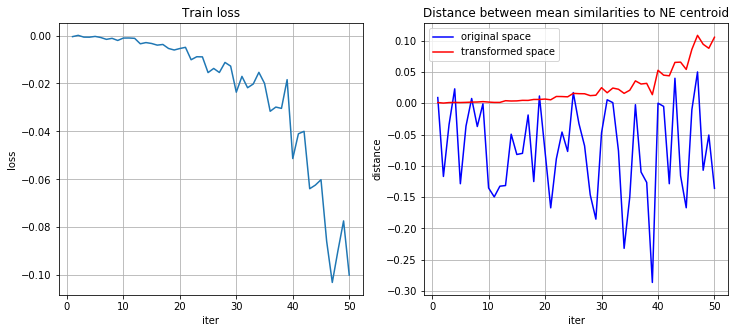

In [12]:
steps_list = np.arange(len(loss_list))+1
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1, title='Train loss')
plt.plot(steps_list, loss_list)
plt.xlabel('iter')
plt.ylabel('loss')
plt.grid()
plt.subplot(1, 2, 2, title='Distance between mean similarities to NE centroid')
plt.plot(steps_list, d_sim_list, c='b', label='original space')
plt.plot(steps_list, d_sim_f_list, c='r', label='transformed space')
plt.xlabel('iter')
plt.ylabel('distance')
plt.grid()
plt.legend()

### Test model

In [13]:
data_test = {}
tokens, tags = get_data_sample(dataset['test'], 10)
data_test['support'] = (tokens, tags)
tokens, tags = get_data_sample(dataset['test'], 100)
data_test['query'] = (tokens, tags)
print(len(data_test['support'][0]))
print(len(data_test['query'][0]))

10
100


In [14]:
X_test_s, y_test_s = get_matrices(data_test['support'][0], data_test['support'][1], embedder)
X_test_q, y_test_q = get_matrices(data_test['query'][0], data_test['query'][1], embedder)

In [15]:
print(X_test_s.shape)
print(X_test_q.shape)

(243, 100)
(2368, 100)


In [16]:
# Apply encoder
x = tf.placeholder('float', [None, n_input])
X_enc_s = sess.run([encoder(x, params)], {x: X_test_s})[0] 
X_enc_q = sess.run([encoder(x, params)], {x: X_test_q})[0]
print(X_enc_s.shape)
print(X_enc_q.shape)

(243, 25)
(2368, 25)


In [17]:
def normalize(x: np.ndarray):
    return x/np.tile(np.expand_dims(np.linalg.norm(x, axis=-1), axis=-1), x.shape[-1])
def calc_sim(x1: np.ndarray, x2: np.ndarray, sim_type='cosine'):
    if sim_type == 'euc_dist':
        return np.exp(-np.linalg.norm(x1 - x2, axis=-1))
    elif sim_type == 'dot_prod':
        return np.dot(x1, x2.T)
    elif sim_type == 'cosine':
        return np.dot(normalize(x1), normalize(x2).T)

In [18]:
def calc_sim_ne_centroid(X_support, y_support, X_query):
    X_sup_ne = X_support[y_support == 1, :]
    X_sup_words = X_support[y_support == 0, :]
    ne_sup_centroid = np.mean(X_sup_ne, axis=0)
    sim_q_list = calc_sim(X_query, ne_sup_centroid, sim_type='cosine')
    return sim_q_list

In [19]:
def plotPDE(sims, y, info=''):
    sims_words = sims[y == 0]
    sims_ne = sims[y == 1]
    plt.figure(figsize=(7,5))
    kde_words = gaussian_kde(sims_words)
    dist_space_words = linspace(min(sims_words), max(sims_words), 100)
    kde_ne = gaussian_kde( sims_ne )
    dist_space_ne = linspace(min(sims_ne), max(sims_ne), 100)
    plt.plot( dist_space_words, kde_words(dist_space_words), color='green', label='words' )
    plt.plot( dist_space_ne, kde_ne(dist_space_ne), color='red',  label='named entities' )
    plt.legend(loc='upper right')
    plt.title('Cosine NE similarity PDE ({})'.format(info))
    plt.grid()

In [20]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
def plot_tSNE(X, y: np.ndarray, colors=('g', 'r'), labels=('words','entities'), title='', use_pca=False, subplot=None):
    X = deepcopy(X)
    if use_pca:
        X = PCA(n_components=50).fit_transform(X)
    tsne = TSNE(n_components=2, method='exact', init='pca')
    X_2d = tsne.fit_transform(X)
    if not subplot:
        plt.figure()
    else:
        plt.subplot(subplot['nrows'], subplot['ncols'], subplot['index'], title=title)
    for i in range(2):
        X_sel = X_2d[y == i, :]
        plt.scatter(X_sel[:, 0], X_sel[:, 1], c=colors[i], alpha= 0.5, label=labels[i])
    plt.legend()
    if not subplot:
        plt.title(title)

In [21]:
sims_orig = calc_sim_ne_centroid(X_test_s, y_test_s, X_test_q)
plotPDE(sims_orig, y_test_q, 'Initial features')

/home/kostrovskiy/prog/AI/NLP/DeepPavlov/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


ValueError: array must not contain infs or NaNs

<Figure size 504x360 with 0 Axes>

In [ ]:
y_pred_orig = np.zeros(y_test_q.size)
y_pred_orig[sims_orig > 0.3] = 1
f1_orig = f1_score(y_test_q, y_pred_orig)
print('F1 score = {:.2f}'.format(f1_orig*100))

In [ ]:
sims_enc = calc_sim_ne_centroid(X_enc_s, y_test_s, X_enc_q)
plotPDE(sims_enc, y_test_q, 'Transformed features')

In [ ]:
y_pred_enc = np.zeros(y_test_q.size)
y_pred_enc[sims_enc > 0.5] = 1
f1_enc = f1_score(y_test_q, y_pred_enc)
print('F1 score = {:.2f}'.format(f1_enc*100))

In [ ]:
plt.figure(figsize=(12,5))
plot_tSNE(X_test_q, y_test_q, title='Initial features', subplot={'nrows': 1, 'ncols': 2, 'index': 1})
plot_tSNE(X_enc_q, y_test_q, title='Transformed features', subplot={'nrows': 1, 'ncols': 2, 'index': 2})

### Test on different NE type

In [ ]:
ne_type_transfer = 'LOC'
dataset_transfer = filter_dataset_by_ne_types(dataset_orig, ne_type_transfer)
data_transfer = {}
tokens, tags = get_data_sample(dataset_transfer['test'], 10)
data_transfer['support'] = (tokens, tags)
tokens, tags = get_data_sample(dataset_transfer['test'], 100)
data_transfer['query'] = (tokens, tags)
print(len(data_transfer['support'][0]))
print(len(data_transfer['query'][0]))

In [ ]:
X_tran_s, y_tran_s = get_matrices(data_transfer['support'][0], data_transfer['support'][1], embedder)
X_tran_q, y_tran_q = get_matrices(data_transfer['query'][0], data_transfer['query'][1], embedder)
print(X_tran_s.shape)
print(X_tran_q.shape)

In [ ]:
# Apply encoder
x = tf.placeholder('float', [None, n_input])
X_enc_s = sess.run([encoder(x, params)], {x: X_tran_s})[0] 
X_enc_q = sess.run([encoder(x, params)], {x: X_tran_q})[0]
print(X_enc_s.shape)
print(X_enc_q.shape)

In [ ]:
sims_orig = calc_sim_ne_centroid(X_tran_s, y_tran_s, X_tran_q)
plotPDE(sims_orig, y_tran_q, 'Initial features')

In [ ]:
y_pred_orig = np.zeros(y_tran_q.size)
y_pred_orig[sims_orig > 0.3] = 1
f1_orig = f1_score(y_tran_q, y_pred_orig)
print('F1 score = {:.2f}'.format(f1_orig*100))

In [ ]:
sims_enc = calc_sim_ne_centroid(X_enc_s, y_tran_s, X_enc_q)
plotPDE(sims_enc, y_tran_q, 'Transformed features')

In [ ]:
y_pred_enc = np.zeros(y_tran_q.size)
y_pred_enc[sims_enc > 0.5] = 1
f1_enc = f1_score(y_tran_q, y_pred_enc)
print('F1 score = {:.2f}'.format(f1_enc*100))

In [ ]:
plt.figure(figsize=(12,5))
plot_tSNE(X_tran_q, y_tran_q, title='Initial features', subplot={'nrows': 1, 'ncols': 2, 'index': 1})
plot_tSNE(X_enc_q, y_tran_q, title='Transformed features', subplot={'nrows': 1, 'ncols': 2, 'index': 2})